In [1]:
%cd /content/drive/MyDrive/Colab/Transliterate/Main/

/content/drive/MyDrive/Colab/Transliterate/Main


In [2]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.6 MB/s 


In [17]:
import os
import json

import pandas as pd

import tensorflow as tf

from encoder import Encoder
from decoder import Decoder, translate

# Hyperparameters

In [4]:
embedding_dim = 256
units = 1024
BATCH_SIZE = 64
BUFFER_SIZE = 120000

max_length_input = 47
max_length_output = 49

# Load Vocab

In [5]:
with open('./data/hindi_tokens.json') as f:
    data = json.load(f)
    input_lang_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

with open('./data/english_tokens.json') as f:
    data = json.load(f)
    target_lang_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

vocab_inp_size = len(input_lang_tokenizer.word_index)+1
vocab_tar_size = len(target_lang_tokenizer.word_index)+1

# Encoder, Decoder, optimizer

In [6]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, 
                  max_length_input, max_length_output, 'luong')
optimizer = tf.keras.optimizers.Adam()

In [7]:
# sample input
example_input_batch = tf.random.uniform(shape=[64,47])
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder h vecotr shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (64, 47, 1024)
Encoder h vecotr shape: (batch size, units) (64, 1024)
Encoder c vector shape: (batch size, units) (64, 1024)


In [8]:
# Test decoder stack
example_target_batch = tf.random.uniform(shape=[64,49])
sample_x = tf.random.uniform((BATCH_SIZE, max_length_output))
decoder.attention_mechanism.setup_memory(sample_output)
initial_state = decoder.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)

sample_decoder_outputs = decoder(sample_x, initial_state)

print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)

Decoder Outputs Shape:  (64, 48, 36)


# Restore the latest checkpoint

In [9]:
checkpoint_dir = './data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [10]:
tf.train.latest_checkpoint(checkpoint_dir)

'./data/training_checkpoints/ckpt-16'

In [11]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [12]:
encoder.embedding.variables

[<tf.Variable 'encoder/embedding/embeddings:0' shape=(166, 256) dtype=float32, numpy=
 array([[-0.05789247, -0.05761706,  0.02359108, ..., -0.02519219,
          0.00357639,  0.01821649],
        [-0.10162569,  0.16787839,  0.07515186, ..., -0.00349098,
          0.1095918 , -0.15538824],
        [-0.16587584, -0.03577255, -0.01891636, ..., -0.0088463 ,
         -0.06838183, -0.2139026 ],
        ...,
        [-0.17257637,  0.12110738,  0.04137989, ..., -0.07441133,
          0.0579181 ,  0.01120433],
        [ 0.14117908, -0.18636873, -0.05861941, ...,  0.06990251,
         -0.2155933 ,  0.14242741],
        [-0.00366263,  0.01715398, -0.0158137 , ...,  0.16398238,
         -0.10098743,  0.12626456]], dtype=float32)>]

In [13]:
decoder.embedding.variables

[<tf.Variable 'decoder/embedding_1/embeddings:0' shape=(36, 256) dtype=float32, numpy=
 array([[ 0.03724634, -0.02989709, -0.04813312, ..., -0.00780924,
          0.00926129,  0.04338977],
        [ 0.34583732, -0.17232183, -0.43789735, ...,  0.5467175 ,
          0.10759091, -0.3757458 ],
        [ 0.09607859,  0.03775342, -0.02386252, ...,  0.05660833,
         -0.04309656, -0.05559392],
        ...,
        [-0.22139364,  0.01528357,  0.03857458, ...,  0.06938541,
          0.0544119 , -0.1216424 ],
        [ 0.15152052, -0.08498745,  0.10692687, ...,  0.02095544,
         -0.06592558, -0.20377964],
        [ 0.12033921,  0.09701973, -0.10407609, ...,  0.00369695,
          0.13182832,  0.00884839]], dtype=float32)>]

# Basic Decoder

In [14]:
test_input = 'राजशेखर चिंतालपति'
translate(test_input, units, input_lang_tokenizer, target_lang_tokenizer, 
          encoder, decoder, max_length_input)

'rajshekhar chinthalpati'

In [15]:
test_input = 'गौरव सूद'
translate(test_input, units, input_lang_tokenizer, target_lang_tokenizer, 
          encoder, decoder, max_length_input)

'gaurav sud'

# Validation on Dakshina Test Dataset

In [18]:
dakshina_test_df = pd.read_csv('./data/hi.translit.sampled.test.tsv', sep='\t', names=["hindi", "english", "freq"])

## Comparing with indic-trans

### Installing indic-trans

In [19]:
pip install -r ../indic-trans/requirements.txt

     |████████████████████████████████| 112 kB 5.1 MB/s 


In [21]:
pip install ../indic-trans

Processing /content/drive/My Drive/Colab/Transliterate/indic-trans
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for indictrans: filename=indictrans-1.2.3-cp37-cp37m-linux_x86_64.whl size=337557214 sha256=6f06ac7419977cc75ea0f6a494940e39a802abc269466f0dca9ce7d700d2ad8e
  Stored in directory: /root/.cache/pip/wheels/10/1f/11/be5ddc8ef916e474d3203c4e9f075763964649ad4363904253
Successfully built indictrans


### Test indic-trans

In [22]:
from indictrans import Transliterator
trn = Transliterator(source='hin', target='eng', build_lookup=True)
eng = trn.transform("राजशेखर चिंतालपति")
eng

'rajasekhar chintalapati'

### Quick diff between model and indic-trans

In [25]:
dakshina_test_df.style.hide_index()
def test_compare(x):
  print(f"{x['hindi']} :  actual - {x['english']}, Model predicted - {translate(x['hindi'], units, input_lang_tokenizer, target_lang_tokenizer, encoder, decoder, max_length_input)}, indicTrans predicted - {trn.transform(x['hindi'])}")
dakshina_test_df.sample(10).apply(lambda x: test_compare(x), axis=1).to_string(index=False)

फारसी :  actual - farsi, Model predicted - farisi, indicTrans predicted - farsi
ग्रंथियों :  actual - grandhiyon, Model predicted - granthion, indicTrans predicted - grathiyon
वायना :  actual - vayna, Model predicted - wayna, indicTrans predicted - vaayana
गुजारते :  actual - gujarte, Model predicted - gujarte, indicTrans predicted - gujaarte
बैला :  actual - bella, Model predicted - baila, indicTrans predicted - baila
महाजन :  actual - mhajan, Model predicted - mahajan, indicTrans predicted - mahajan
श्रंखला :  actual - shrankhala, Model predicted - shrankhala, indicTrans predicted - shrankhla
वर्तमान :  actual - vartamaan, Model predicted - varthaman, indicTrans predicted - vartmaan
इशिता :  actual - ishita, Model predicted - ishita, indicTrans predicted - ishita
कमेरे :  actual - kmere, Model predicted - kamere, indicTrans predicted - camere


' None\n None\n None\n None\n None\n None\n None\n None\n None\n None'

### Get predictions on Dakshina Test DS using model and indic-trans

In [28]:
from tqdm import tqdm
tqdm.pandas()

dakshina_test_df.style.hide_index()
predicted = []
indictrans = []

def predict(hin):
  predicted.append(translate(hin, units, input_lang_tokenizer, target_lang_tokenizer, 
          encoder, decoder, max_length_input))
  indictrans.append(trn.transform(hin))

dakshina_test_df.progress_apply(lambda x: predict(x['hindi']), axis=1)

100%|██████████| 4502/4502 [05:22<00:00, 13.97it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
4497    None
4498    None
4499    None
4500    None
4501    None
Length: 4502, dtype: object

In [29]:
dakshina_test_df['model_predicted'] = predicted
dakshina_test_df['indictrans_predicted'] = indictrans
dakshina_test_df.head()

,hindi,english,freq,model_predicted,indictrans_predicted
0,अंक,ank,5,ank,ank
1,अंक,anka,1,ank,ank
2,अंकित,ankit,3,ankit,ankit
3,अंकों,anakon,1,ankon,ankon
4,अंकों,ankhon,1,ankon,ankon


### Calculate edit distance

In [30]:
def edit_distance(s1, s2):
  t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split(s1), axis=0))
  t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split(s2), axis=0))
  distance = tf.edit_distance(t1, t2)
  return distance[0].numpy()

model_edit_dist = []
indic_edit_dist = []

def edit_dist(x):
  model_edit_dist.append(edit_distance(x['model_predicted'], x['english']))
  indic_edit_dist.append(edit_distance(x['indictrans_predicted'], x['english']))

dakshina_test_df.progress_apply(lambda x: edit_dist(x), axis=1)

100%|██████████| 4502/4502 [02:46<00:00, 27.03it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
4497    None
4498    None
4499    None
4500    None
4501    None
Length: 4502, dtype: object

In [31]:
dakshina_test_df['model_edit_distance'] = model_edit_dist
dakshina_test_df['indic_edit_distance'] = indic_edit_dist
dakshina_test_df.head()

,hindi,english,freq,model_predicted,indictrans_predicted,model_edit_distance,indic_edit_distance
0,अंक,ank,5,ank,ank,0.000000,0.000000
1,अंक,anka,1,ank,ank,0.250000,0.250000
2,अंकित,ankit,3,ankit,ankit,0.000000,0.000000
3,अंकों,anakon,1,ankon,ankon,0.166667,0.166667
4,अंकों,ankhon,1,ankon,ankon,0.166667,0.166667


### Save above results

In [32]:
dakshina_test_df.to_csv('./data/dakshina_test_results.csv',index=False)

### Plotting edit distance for both model and indic-trans

### Indic trans edit distance plot

(array([1.578e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.300e+01, 2.000e+01, 3.900e+01, 8.300e+01, 1.370e+02,
        2.180e+02, 1.000e+00, 2.650e+02, 1.200e+01, 3.430e+02, 0.000e+00,
        3.300e+01, 0.000e+00, 3.050e+02, 1.000e+00, 1.010e+02, 3.000e+00,
        0.000e+00, 2.630e+02, 1.000e+00, 9.000e+00, 1.610e+02, 0.000e+00,
        3.100e+01, 0.000e+00, 0.000e+00, 2.560e+02, 0.000e+00, 0.000e+00,
        8.000e+00, 5.300e+01, 0.000e+00, 0.000e+00, 1.460e+02, 2.000e+00,
        7.400e+01, 0.000e+00, 9.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.480e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 2.300e+01, 1.000e+00, 0.000e+00,
        4.300e+01, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.900e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+01, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+0

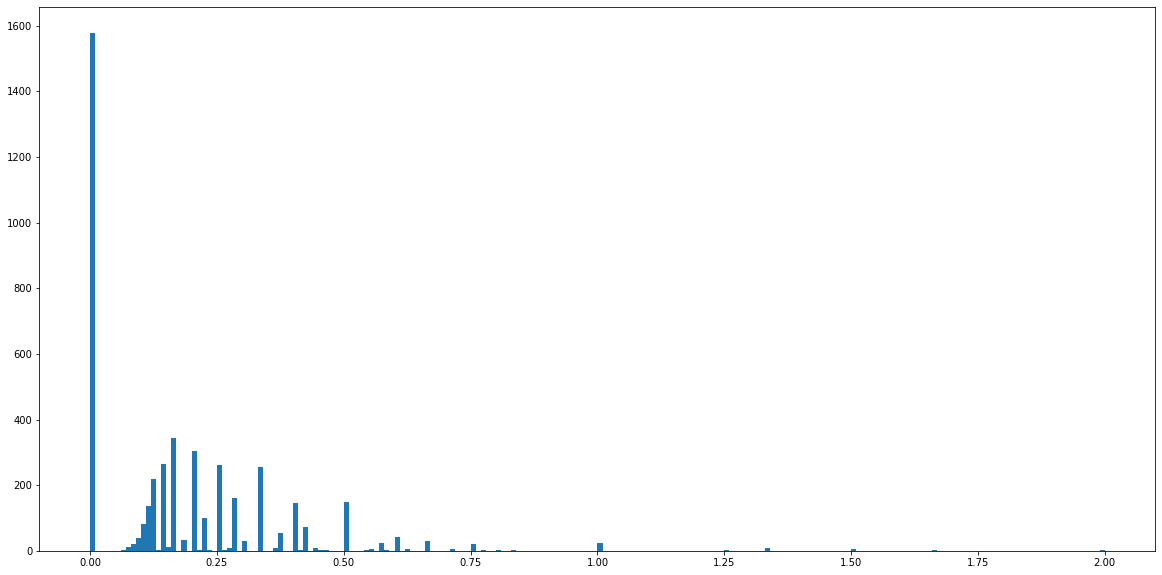

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
plt.hist(indic_edit_dist, bins=np.arange(min(indic_edit_dist), max(indic_edit_dist)+0.01, step=0.01))

#### Model edit distance plot

(array([1.841e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.300e+01, 2.400e+01, 3.100e+01, 8.600e+01, 1.280e+02,
        2.100e+02, 0.000e+00, 2.740e+02, 7.000e+00, 2.970e+02, 0.000e+00,
        3.600e+01, 0.000e+00, 2.910e+02, 2.000e+00, 9.600e+01, 0.000e+00,
        0.000e+00, 2.300e+02, 0.000e+00, 9.000e+00, 1.570e+02, 0.000e+00,
        1.700e+01, 0.000e+00, 0.000e+00, 2.190e+02, 0.000e+00, 0.000e+00,
        1.000e+01, 3.700e+01, 1.000e+00, 0.000e+00, 1.330e+02, 2.000e+00,
        5.300e+01, 0.000e+00, 1.000e+01, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.380e+02, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.100e+01, 0.000e+00, 1.400e+01, 0.000e+00, 0.000e+00,
        2.500e+01, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        3.400e+01, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.900e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 8.000e+0

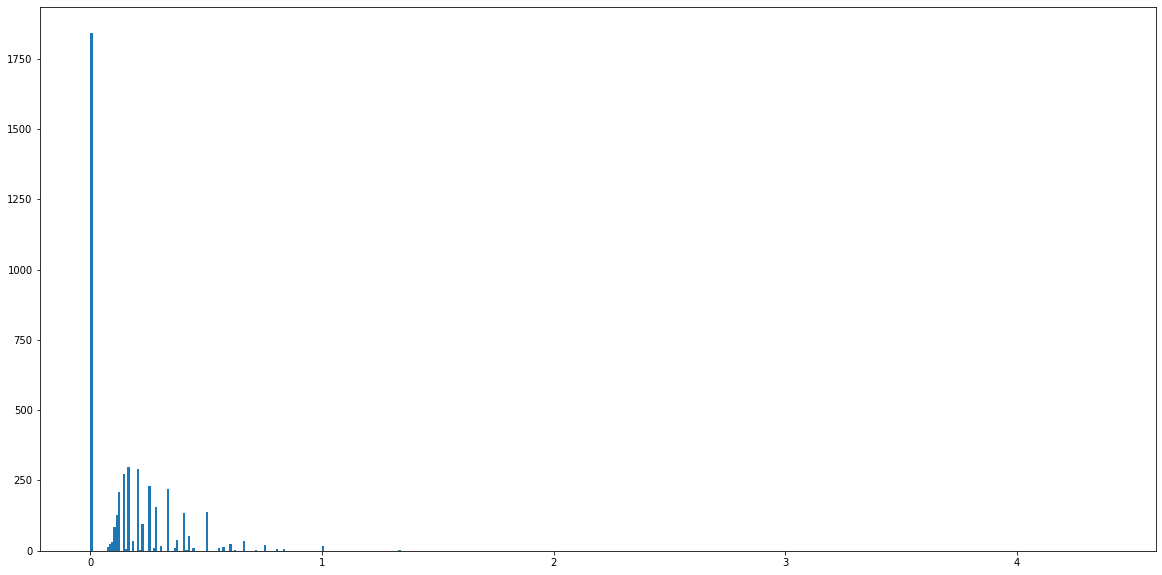

In [35]:
plt.figure(figsize=(20,10))
plt.hist(model_edit_dist, bins=np.arange(min(model_edit_dist), max(model_edit_dist)+0.01, step=0.01))

### Remove duplicate entries

In [36]:
model_edit_dedup = dakshina_test_df.groupby(['hindi'])['model_edit_distance'].min().reset_index()
indic_edit_dedup = dakshina_test_df.groupby(['hindi'])['indic_edit_distance'].min().reset_index()

In [37]:
model_acc_percent = len(model_edit_dedup[model_edit_dedup['model_edit_distance'] == 0])/len(model_edit_dedup)
indic_acc_percent = len(indic_edit_dedup[indic_edit_dedup['indic_edit_distance'] == 0])/len(indic_edit_dedup)
print(f"Out of {len(model_edit_dedup)}, model predicted {model_acc_percent * 100}% correctly")
print(f"Out of {len(indic_edit_dedup)}, indic predicted {indic_acc_percent * 100}% correctly")

Out of 2500, model predicted 73.64% correctly
Out of 2500, indic predicted 63.12% correctly
